In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import sys

Populating the interactive namespace from numpy and matplotlib


In [267]:
max_seq_len = 30
batch_size = 1

### Import dataset

In [4]:
import json

DATADIR = 'data/'

word2ix_src_file = 'word2ix_en_filtered.json'
ix2word_src_file = 'ix2word_en_filtered.json'
word2ix_tgt_file = 'word2ix_fr_filtered.json'
ix2word_tgt_file = 'ix2word_fr_filtered.json'

pairs_file = 'pairs_en_fr_filtered.json'

with open(DATADIR + word2ix_src_file) as f:
    word2ix_src = json.load(f)
with open(DATADIR + ix2word_src_file) as f:
    ix2word_src = json.load(f)
with open(DATADIR + word2ix_tgt_file) as f:
    word2ix_tgt = json.load(f)
with open(DATADIR + ix2word_tgt_file) as f:
    ix2word_tgt = json.load(f)

with open(DATADIR + pairs_file) as f:
    pairs = json.load(f)
    
source_vocab_size = len(word2ix_src)
target_vocab_size = len(word2ix_tgt)

n_pairs = len(pairs)
np.random.shuffle(pairs)

#split into three subsets (train, dev, test)
train_pairs = pairs[:(9 * n_pairs// 10)] #90%
dev_pairs = pairs[(9 * n_pairs // 10):(19 * n_pairs // 20)] #5%
test_pairs = pairs[(19 * n_pairs // 20):]


In [5]:
def generate_pairs_batch(update_num, mode='train'):
    #0 is UNK, 1 is BOS, 2 is EOS, 3 is PAD
    #bos is only used in target_in
    # i is # of update
    
    if mode == 'train':
        dataset = train_pairs
    elif mode == 'dev':
        dataset = dev_pairs
    elif mode == 'test':
        dataset = test_pairs
        
    num_pairs = len(dataset)
    
    index = (update_num * batch_size) % num_pairs
    inputs_batch = []
    targets_in_batch = []
    targets_out_batch = []

    max_src_len = 0
    max_tgt_len = 0
    for j in range(batch_size):
        pair = pairs[(index + j) % num_pairs]   #modulo used so that we are always in the index range
        
        inputs = pair['source']
        targets_in = pair['target']
        targets_out = pair['target']
        
        # add <BOS> and <EOS> tokens
        inputs = inputs + [int(word2ix_src['<EOS>'])]
        targets_in = [int(word2ix_tgt['<BOS>'])] + targets_in
        targets_out = targets_out + [int(word2ix_tgt['<EOS>'])]
        
        if len(inputs) > max_src_len:
            max_src_len = len(inputs)
        if len(targets_out) > max_tgt_len:
            max_tgt_len = len(targets_out)
        
        # adding to batch
        inputs_batch.append(inputs)
        targets_in_batch.append(targets_in)
        targets_out_batch.append(targets_out)
    
    #padding sequences to same length
    for j in range(batch_size):
        
        tmp = len(inputs_batch[j])
        inputs_batch[j] = inputs_batch[j] + (max_src_len - tmp) * [int(word2ix_src['<PAD>'])]
        
        tmp = len(targets_out_batch[j])
        targets_in_batch[j] = targets_in_batch[j] + (max_tgt_len - tmp) * [int(word2ix_src['<PAD>'])]
        targets_out_batch[j] = targets_out_batch[j] + (max_tgt_len - tmp) * [int(word2ix_src['<PAD>'])]
        
    
    inputs_batch = torch.LongTensor(inputs_batch).t()
    targets_in_batch = torch.LongTensor(targets_in_batch).t()
    targets_out_batch = torch.LongTensor(targets_out_batch).t()
    
    return inputs_batch, targets_in_batch, targets_out_batch
    

### Creating models

In [6]:
class Seq2Seq(nn.Module):
    
    def __init__(self, source_vocab_size, target_vocab_size, embedding_size=256, hidden_size=256,
                 attention_size=256, num_layers=1, max_seq_len=30):
        super(Seq2Seq, self).__init__()
        
        self.max_seq_len = max_seq_len
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        
        self.encoder = Encoder(input_size=source_vocab_size, 
                               embedding_size=embedding_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers)
        
        self.decoder = Decoder(output_size=target_vocab_size,
                               embedding_size=embedding_size,
                               hidden_size=hidden_size,
                               attention_size=attention_size,
                               num_layers=num_layers)


In [7]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, embedding_size=256, hidden_size=256,
                 num_layers=1):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.hidden0 = nn.Parameter(torch.zeros(2*num_layers, 1, hidden_size//2))
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.encoder_rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size//2, 
                                  num_layers=num_layers, bidirectional=True)
        
    def forward(self, x):
        
        hidden = self._init_hidden()
        
        x = self.embedding(x)
        x, hidden = self.encoder_rnn(x, hidden)

        return x, hidden

    def _init_hidden(self):
        # initial hidden state is a learned bias parameter
        hidden = self.hidden0.clone().repeat(1, batch_size, 1)
        if use_cuda:
            hidden = hidden.cuda()

        return hidden


In [8]:
class Decoder(nn.Module):
    
    def __init__(self, output_size, embedding_size=256, hidden_size=256,
                 attention_size=256, num_layers=1):
        """
        We use the original attention mechanism from Bahdanau et al. 2014
        The layers are of this model correspond to the following notation in the original paper.
        
        attn_fc_prev_hid : Wa
        attn_fc_enc_hid : Ua
        attn_fc_context : va
        """
        super(Decoder, self).__init__()
        
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.attention_size = attention_size
        self.num_layers=num_layers
        
        # attention
        self.attn_fc_prev_hid = nn.Linear(in_features=hidden_size, 
                                          out_features=attention_size)
        self.attn_fc_enc_hid = nn.Linear(in_features=hidden_size, 
                                         out_features=attention_size)
        self.attn_fc_context = nn.Linear(in_features=attention_size,
                                         out_features=1)
    
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=embedding_size)    
        self.decoder_rnn = nn.GRU(input_size=(embedding_size + hidden_size), 
                                  hidden_size=hidden_size, 
                                  num_layers=num_layers)
        self.clf = nn.Linear(in_features=hidden_size, out_features=output_size)
        
        
    def forward(self, x, encoder_outputs):
        
        x = x.unsqueeze(0)
        
        # attention
        tmp1 = self.attn_fc_prev_hid(self.hidden[0])
        tmp2 = self.attn_fc_enc_hid(encoder_outputs)

        context_weights = self.attn_fc_context(F.tanh(tmp1 + tmp2))
        context_weights = F.softmax(context_weights, 0)
        self.attn_weights = context_weights #for attention plotting purposes
        
        context_weights = context_weights.permute(1, 2, 0) # (batch size x 1 x seq_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch size x seq_len x 2*hidden_dim)

        context_vector = torch.bmm(context_weights, encoder_outputs)
        context_vector = context_vector.permute(1, 0, 2) # (1 x batch_size x 2*hidden_dim)
        
        x = self.embedding(x)
        #concatenate previously predicted word embedding and context vector
        x = torch.cat((x, context_vector), dim=-1)
        x, self.hidden = self.decoder_rnn(x, self.hidden)
        x = self.clf(x)
        
        x = F.log_softmax(x, dim=-1)

        return x

    def _init_hidden(self, encoder_hidden_state):
        
        self.hidden = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        if use_cuda:
            self.hidden = self.hidden.cuda()
        for layer in range(self.num_layers):
            self.hidden[layer] = torch.cat((encoder_hidden_state[2*layer],
                                    encoder_hidden_state[2*layer + 1]), dim=-1)
        

### Training loop

In [190]:
def train(model, n_updates=10000, teacher_forcing_prob=0.8, print_every=1000, 
          learning_rate=1e-4, save_model=False, beam_size=10):

    if use_cuda:
        model = model.cuda()

    #PAD has no weight
    weight_mask = torch.ones(len(word2ix_tgt))
    weight_mask[int(word2ix_tgt['<PAD>'])] = 0
    if use_cuda:
        weight_mask = weight_mask.cuda()
    criterion = nn.NLLLoss(weight=weight_mask)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    loss_buffer = []
    bleu_tracker = []
    loss_tracker = []

    # + 1 to show the last update
    for update in range(n_updates + 1):
        
        loss = 0
        teacher_forcing = True if np.random.random() < teacher_forcing_prob else False
        
        optimizer.zero_grad()

        inputs, targets_in, targets_out = generate_pairs_batch(update)
        inputs, targets_in, targets_out = Variable(inputs), Variable(targets_in), Variable(targets_out)
        if use_cuda:
            inputs, targets_in, targets_out = inputs.cuda(), targets_in.cuda(), targets_out.cuda()

        encoder_outputs, encoder_hidden = model.encoder(inputs)
        
        model.decoder._init_hidden(encoder_hidden)
        
        predicted_sequence = torch.zeros(len(targets_in)).long()
        if use_cuda:
            predicted_sequence = predicted_sequence.cuda()

        if teacher_forcing:
            for i in range(len(targets_in)):
                output = model.decoder(targets_in[i], encoder_outputs)

                loss += criterion(output.view(batch_size, -1), targets_out[i])

                _, output = torch.max(output, -1)
                output = output.view(batch_size)

                predicted_sequence[i] = output.data[0]
                
        else:
            # beam search
            # feeding BOS tokens
            output = Variable(torch.ones(batch_size).long())
            beam_best_seq = torch.zeros(len(targets_in), batch_size, beam_size).long()
            beam_best_scores = torch.zeros(batch_size, beam_size)
            beam_seq_buffer = torch.zeros(len(targets_in), batch_size, beam_size*beam_size).long()
            beam_scores_buffer = torch.zeros(batch_size, beam_size*beam_size)
            if use_cuda:
                output = output.cuda()
                beam_best_seq = beam_best_seq.cuda()
                beam_best_scores = beam_best_scores.cuda()
                beam_seq_buffer = beam_seq_buffer.cuda()
                beam_scores_buffer = beam_scores_buffer.cuda()
            for i in range(len(targets_in)):
                if i == 0:
                    output = model.decoder(output, encoder_outputs)
                    top_vals, top_ix = torch.topk(output, beam_size)
                    beam_best_scores = top_vals[0].data
                    beam_best_seq[i] = top_ix.data
                else:
                    for j in range(beam_size):
                        output = Variable(beam_best_seq[i-1,:,j])
                        if use_cuda:
                            output = output.cuda()
                        output = model.decoder(output, encoder_outputs)
                        
                        top_vals, top_ix = torch.topk(output, beam_size)
                        top_vals = beam_best_scores[:,j].unsqueeze(-1) + top_vals.data
                        
                        #building buffers
                        beam_scores_buffer[:,j*beam_size:(j+1)*beam_size] = top_vals
                
                        beam_seq_buffer[:i,:,j*beam_size:(j+1)*beam_size] = beam_best_seq[:i,:,j:j+1].repeat(1, 1, beam_size)
                        beam_seq_buffer[i,:,j*beam_size:(j+1)*beam_size] = top_ix.data

                    # keeping best beams from buffer
                    top_vals, top_ix = torch.topk(beam_scores_buffer, beam_size)
                    
                    # updating best sequences and best scores
                    beam_best_scores = top_vals
                    
                    
                    for k in range(batch_size):
                        for j in range(beam_size):
                            ix = top_ix[k,j]
                            beam_best_seq[:,k,j] = beam_seq_buffer[:,k,ix]
            
            #re-run with best sequence
            best_prediction = beam_best_seq[:,:,0]
            best_prediction = Variable(best_prediction)
            output = Variable(torch.ones(batch_size)).long()
            if use_cuda:
                best_prediction = best_prediction.cuda()
                output = output.cuda()

            for i in range(len(targets_in)):  
                output = model.decoder(output, encoder_outputs) 

                _, predicted_word = torch.max(output, -1)
                predicted_word = predicted_word.view(batch_size)
                predicted_sequence[i] = predicted_word.data[0]

                loss += criterion(output.view(batch_size, -1), targets_out[i])
                
                #using the beam search prediction
                output = best_prediction[i]
            
                predicted_sequence[i] = output.data[0]

        loss /= len(targets_in) # length penalty
        
        loss.backward()
        optimizer.step()  
        
        loss_buffer.append(loss.data[0])

        if update % print_every == 0:
            
            inputs = inputs[:,0]
            targets_out = targets_out[:,0]

            # convert all sequence to list (easier to read)
            inputs = [str(inputs.data[i]) for i in range(len(inputs))]
            predicted_sequence = [str(predicted_sequence[i]) for i in range(len(predicted_sequence))]
            targets_out = [str(targets_out.data[i]) for i in range(len(targets_out))]

            # create string of sentence
            og_sequence = ''.join(ix2word_src[elem] + ' ' for elem in inputs if ix2word_tgt[elem] != '<PAD>')
            pred_sequence = ''.join(ix2word_tgt[elem] + ' ' for elem in predicted_sequence if ix2word_tgt[elem] != '<PAD>')
            target_sequence = ''.join(ix2word_tgt[elem] + ' ' for elem in targets_out if ix2word_tgt[elem] != '<PAD>')
            
            #mean over print_every batches of loss
            loss_tracker.append(np.mean(loss_buffer))
            loss_buffer = []
            
            #score = compute_bleu_score(model, mode='dev')
            score = 0
            bleu_tracker.append(score)
            
            print("Update : %d ----- Loss : %.3f ----- BLEU : %.2f\n-----------------------------" % (update, loss_tracker[-1], bleu_tracker[-1]))
            print("Original sequence  : %s" % og_sequence)
            print("Predicted sequence : %s" % pred_sequence)
            print("Target sequence    : %s\n" % target_sequence)
            
            if save_model:
                #saving encoder and decoder separately
                torch.save(model.encoder.state_dict(), 'seq2seq_encoder_en_fr.pt')
                torch.save(model.decoder.state_dict(), 'seq2seq_decoder_en_fr.pt')
                
                #saving loss progress
                np.savetxt('seq2seq_en_fr_loss.txt', np.array(loss_tracker))
                np.savetxt('seq2seq_en_fr_bleu.txt', np.array(bleu_tracker))
    
    return loss_tracker


In [169]:
model = Seq2Seq(source_vocab_size=source_vocab_size, target_vocab_size=target_vocab_size, num_layers=2)

In [12]:
model.encoder.load_state_dict(torch.load('seq2seq_encoder_en_fr.pt'))
model.decoder.load_state_dict(torch.load('seq2seq_decoder_en_fr.pt'))

In [208]:
loss_tracker = train(model, n_updates = 1000000, print_every=1000, save_model=True, beam_size=3)

Update : 0 ----- Loss : 2.983 ----- BLEU : 0.00
-----------------------------
Original sequence  : counter terrorism instruments or policies which do not respect fundamental rights often play into the hands of the terrorists themselves . <EOS> 
Predicted sequence : les fonds de les regions de sante ou ou ne sont pas les droits fondamentaux des des bien les droit des etats . memes . <EOS> . . . . . 
Target sequence    : les instruments ou les politiques de contre terrorisme qui ne respectent pas les droits fondamentaux font tres souvent le jeu des terroristes eux memes . <EOS> 

Update : 1000 ----- Loss : 3.514 ----- BLEU : 0.00
-----------------------------
Original sequence  : although this clause is rarely used it could well be used very soon in finland if i am well informed . <EOS> 
Predicted sequence : en ce n est qu il est difficile . <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> ce ce 
Target sequence    : bien

KeyboardInterrupt: 

In [259]:
import matplotlib.ticker as ticker

def show_attention(model, teacher_forcing=True, beam_size=10):
    
    dataset = train_pairs

    inputs, targets_in, targets_out = generate_pairs_batch(np.random.randint(len(dataset)))
    inputs, targets_in, targets_out = Variable(inputs), Variable(targets_in), Variable(targets_out)
    if use_cuda:
        inputs, targets_in, targets_out = inputs.cuda(), targets_in.cuda(), targets_out.cuda()

    encoder_outputs, encoder_hidden = model.encoder(inputs)

    model.decoder._init_hidden(encoder_hidden)

    predicted_sequences = torch.zeros(len(targets_in), batch_size).long()
    if use_cuda:
        predicted_sequences = predicted_sequences.cuda()
    attention_weights = torch.zeros(len(inputs), len(targets_out))
    """
    for i in range(len(targets_in)):
        output = model.decoder(targets_in[i], encoder_outputs)

        attention_weights[:,i] = model.decoder.attn_weights.data[:,0].squeeze()

        _, output = torch.max(output, -1)
        output = output.view(batch_size)

        predicted_sequences[i] = output.data[0]    
    """
    # beam search
    # feeding BOS tokens
    output = Variable(torch.ones(batch_size).long())
    beam_best_seq = torch.zeros(len(targets_in), batch_size, beam_size).long()
    beam_best_scores = torch.zeros(batch_size, beam_size)
    beam_seq_buffer = torch.zeros(len(targets_in), batch_size, beam_size*beam_size).long()
    beam_scores_buffer = torch.zeros(batch_size, beam_size*beam_size)
    if use_cuda:
        output = output.cuda()
        beam_best_seq = beam_best_seq.cuda()
        beam_best_scores = beam_best_scores.cuda()
        beam_seq_buffer = beam_seq_buffer.cuda()
        beam_scores_buffer = beam_scores_buffer.cuda()
    for i in range(len(targets_in)):
        if i == 0:
            output = model.decoder(output, encoder_outputs)
            top_vals, top_ix = torch.topk(output, beam_size)
            beam_best_scores = top_vals[0].data
            beam_best_seq[i] = top_ix.data
        else:
            for j in range(beam_size):
                output = Variable(beam_best_seq[i-1,:,j])
                if use_cuda:
                    output = output.cuda()
                output = model.decoder(output, encoder_outputs)

                top_vals, top_ix = torch.topk(output, beam_size)
                top_vals = beam_best_scores[:,j].unsqueeze(-1) + top_vals.data

                #building buffers
                beam_scores_buffer[:,j*beam_size:(j+1)*beam_size] = top_vals

                beam_seq_buffer[:i,:,j*beam_size:(j+1)*beam_size] = beam_best_seq[:i,:,j:j+1].repeat(1, 1, beam_size)
                beam_seq_buffer[i,:,j*beam_size:(j+1)*beam_size] = top_ix.data

            # keeping best beams from buffer
            top_vals, top_ix = torch.topk(beam_scores_buffer, beam_size)

            # updating best sequences and best scores
            beam_best_scores = top_vals


            for k in range(batch_size):
                for j in range(beam_size):
                    ix = top_ix[k,j]
                    beam_best_seq[:,k,j] = beam_seq_buffer[:,k,ix]

    #re-run with best sequence
    best_prediction = beam_best_seq[:,:,0]
    best_prediction = Variable(best_prediction)
    output = Variable(torch.ones(batch_size)).long()
    if use_cuda:
        best_prediction = best_prediction.cuda()
        output = output.cuda()

    for i in range(len(targets_in)):  
        output = model.decoder(output, encoder_outputs) 

        attention_weights[:,i] = model.decoder.attn_weights.data[:,0].squeeze()
        output = best_prediction[i]
        predicted_sequences[i,:] = output.data
       
    #preparing the inputs by removing the padding
    attn_in = inputs.data[:,0].cpu().numpy()
    # attn_out = targets_out.data[:,0].cpu().numpy()
    attn_out = predicted_sequences[:,0]
    
    while attn_in[-1] != 2:
        attn_in = attn_in[:-1]
    while attn_out[-1] != 2:
        attn_out = attn_out[:-1]
    
    attention_weights = attention_weights[:len(attn_in), :len(attn_out)]

    attn_in_str = [ix2word_src[str(attn_in[i])] for i in range(len(attn_in))]
    attn_out_str = [ix2word_tgt[str(attn_out[i])] for i in range(len(attn_out))]
    
    # plot figure
    fig, ax = plt.subplots(figsize=(8, 8))    
    ax.matshow(attention_weights.numpy(), cmap='bone')

    # Set up axes
    ax.set_xticklabels([''] + attn_out_str, rotation=90)
    ax.set_yticklabels([''] + attn_in_str)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.savefig("attention.png")

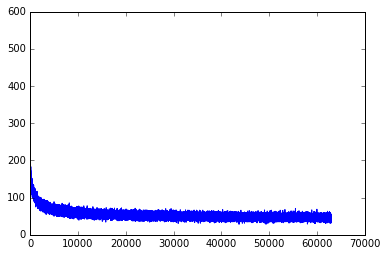

In [62]:
def show_learning_curve(loss_tracker):
    
    plt.plot(loss_tracker)
    plt.show()
    
loss_tracker_file = 'seq2seq_en_fr_loss.txt'
loss_tracker = np.loadtxt(loss_tracker_file)
show_learning_curve(loss_tracker)

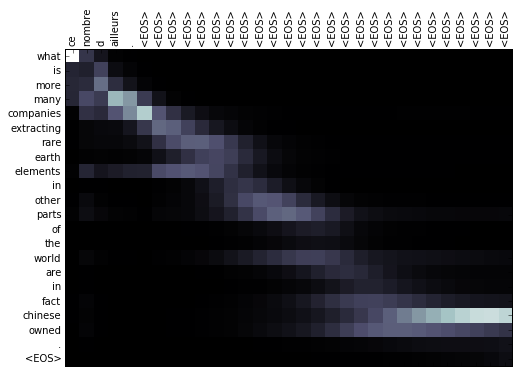

In [266]:
show_attention(model)

In [273]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu_score(model, n_updates=100, mode='dev', beam_size=2, teacher_forcing=True):
    
    score = 0
    #we do a mean over 100 updates for the BLEU score on the dev and test set
    for update in range(n_updates):
        
        inputs, targets_in, targets_out = generate_pairs_batch(update, mode='dev')
        inputs, targets_in, targets_out = Variable(inputs), Variable(targets_in), Variable(targets_out)
        if use_cuda:
            inputs, targets_in, targets_out = inputs.cuda(), targets_in.cuda(), targets_out.cuda()

        encoder_outputs, encoder_hidden = model.encoder(inputs)
        
        model.decoder._init_hidden(encoder_hidden)
        
        predicted_sequences = torch.zeros(batch_size, len(targets_in)).long()
        if use_cuda:
            predicted_sequences = predicted_sequences.cuda()
        
        if teacher_forcing:
            for i in range(len(targets_in)):
                output = model.decoder(targets_in[i], encoder_outputs)

                _, output = torch.max(output, -1)
                output = output.view(batch_size)

                predicted_sequences[:,i] = output.data
        """
        # beam search
        # feeding BOS tokens
        output = Variable(torch.ones(batch_size).long())
        beam_best_seq = torch.zeros(len(targets_in), batch_size, beam_size).long()
        beam_best_scores = torch.zeros(batch_size, beam_size)
        beam_seq_buffer = torch.zeros(len(targets_in), batch_size, beam_size*beam_size).long()
        beam_scores_buffer = torch.zeros(batch_size, beam_size*beam_size)
        if use_cuda:
            output = output.cuda()
            beam_best_seq = beam_best_seq.cuda()
            beam_best_scores = beam_best_scores.cuda()
            beam_seq_buffer = beam_seq_buffer.cuda()
            beam_scores_buffer = beam_scores_buffer.cuda()
        for i in range(len(targets_in)):
            if i == 0:
                output = model.decoder(output, encoder_outputs)
                top_vals, top_ix = torch.topk(output, beam_size)
                beam_best_scores = top_vals[0].data
                beam_best_seq[i] = top_ix.data
            else:
                for j in range(beam_size):
                    output = Variable(beam_best_seq[i-1,:,j])
                    if use_cuda:
                        output = output.cuda()
                    output = model.decoder(output, encoder_outputs)

                    top_vals, top_ix = torch.topk(output, beam_size)
                    top_vals = beam_best_scores[:,j].unsqueeze(-1) + top_vals.data

                    #building buffers
                    beam_scores_buffer[:,j*beam_size:(j+1)*beam_size] = top_vals

                    beam_seq_buffer[:i,:,j*beam_size:(j+1)*beam_size] = beam_best_seq[:i,:,j:j+1].repeat(1, 1, beam_size)
                    beam_seq_buffer[i,:,j*beam_size:(j+1)*beam_size] = top_ix.data

                # keeping best beams from buffer
                top_vals, top_ix = torch.topk(beam_scores_buffer, beam_size)

                # updating best sequences and best scores
                beam_best_scores = top_vals


                for k in range(batch_size):
                    for j in range(beam_size):
                        ix = top_ix[k,j]
                        beam_best_seq[:,k,j] = beam_seq_buffer[:,k,ix]

        #re-run with best sequence
        best_prediction = beam_best_seq[:,:,0]
        best_prediction = Variable(best_prediction)
        output = Variable(torch.ones(batch_size)).long()
        if use_cuda:
            best_prediction = best_prediction.cuda()
            output = output.cuda()

        for i in range(len(targets_in)):  

            output = best_prediction[i]

            predicted_sequences[:,i] = output.data
        """  
        for j in range(batch_size):
            """
            output = ''.join(str(ix2word_tgt[str(word)]) + ' ' for word in predicted_sequences[j] if word not in [0, 1, 2, 3, int(word2ix_src['.'])])
            reference = ''.join(str(ix2word_tgt[str(word)]) + ' ' for word in targets_out[:,j].data if word not in [0, 1, 2, 3, int(word2ix_src['.'])])
            
            with open('output', 'w') as output_file:
                output_file.write(output)

            with open('reference', 'w') as reference_file:
                reference_file.write(reference)

            from os import system
            x = system('./multi-bleu.perl reference < output')
#             score += tmp
            """
            
            output = [str(ix2word_tgt[str(word)]) for word in predicted_sequences[j] if word not in [0, 1, 2, 3, int(word2ix_src['.'])]]
            reference = [str(ix2word_tgt[str(word)]) for word in targets_out[:,j].data if word not in [0, 1, 2, 3, int(word2ix_src['.'])]]
            try:
                tmp = sentence_bleu(reference,output)
            except:
                continue
            if tmp > 0.65:
                print('Source : ' + ''.join(str(ix2word_src[str(word)]) + " " for word in inputs[:,j].data if word not in [0, 1, 2, 3, int(word2ix_src['.'])]))
                print('Output : ' + ''.join(str(ix2word_tgt[str(word)]) + " " for word in predicted_sequences[j] if word not in [0, 1, 2, 3, int(word2ix_src['.'])]))
                print('Target : ' + ''.join(str(ix2word_tgt[str(word)]) + " " for word in targets_out[:,j].data if word not in [0, 1, 2, 3, int(word2ix_src['.'])]))
            
        
    score = score * 100 / (batch_size * n_updates)
    return score

In [274]:
compute_bleu_score(model)

Source : the vote will take place tomorrow at noon 
Output : le vote aura lieu demain a heures . 
Target : le vote aura lieu demain a heures . 
Source : i hope therefore that the commission accepts these positions 
Output : j espere donc que la commission accepte ces positions . 
Target : j espere donc que la commission retiendra ces positions . 
Source : 
Output : souhaits intentions autre s autre autre a l urgence premier urgence le autres autres 
Target : et troisiemement l amendement qui reclamait un rapport annuel sur l application de l acces propose pour les autorites concernees . 
Source : the commission made a clear assessment of this issue 
Output : la commission a fait fait une point . 
Target : la commission a clairement evalue ce probleme . 
Source : mr president first of all i would like to congratulate the commissioner on his successful ban on driftnets which was long overdue 
Output : monsieur le president je voudrais tout d abord feliciter le commissaire pour son une a 

0

In [191]:
compute_bleu_score(model, mode='test')

Average BLEU Score : 0.2428


In [32]:
torch.cuda.empty_cache()

In [16]:
del model

In [33]:
!nvidia-smi

Tue Apr 24 16:10:37 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0  On |                  N/A |
| 27%   39C    P2    32W / 120W |    714MiB /  6069MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [22]:
!top

=top - 15:36:05 up 4 min,  1 user,  load average: 1.62, 1.45, 0.66
Tasks: 340 total,   1 running, 339 sleeping,   0 stopped,   0 zombie
%Cpu(s): 28.7 us,  4.2 sy, 21.2 ni, 42.4 id,  1.8 wa,  0.0 hi,  1.7 si,  0.0 st
KiB Mem : 16383692 total,  6748444 free,  6467688 used,  3167560 buff/cache
KiB Swap: 16729084 total, 16729084 free,        0 used.  9405160 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
 3974 patrice   20   0 1242620 198268  77952 S  12.5  1.2   0:30.56 chrome      
 3285 patrice   20   0 1023196 114152  68972 S   6.2  0.7   0:02.50 compiz      
 3937 patrice   20   0  626056 171800  95372 S   6.2  1.0   0:09.11 chrome      
 4084 patrice   20   0 1276816 203504  59420 S   6.2  1.2   0:06.55 chrome      
    1 root      20   0  185576   6192   3980 S   0.0  0.0   0:01.01 systemd     
    2 root      20   0       0      0      0 S   0.0  0.0   0:00.00 kthreadd    
    3 root      20   0       0      0      0 S   0.0  0.0   0:0

In [ ]:
x = torch.a